In [1]:
!pip install -e ../../../.

Obtaining file:///hhh-vol/hhh
  Preparing metadata (setup.py) ... done


  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src


In [2]:
import logging
from pathlib import Path

import awkward as ak
import click
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import uproot
import vector
from coffea.hist.plot import clopper_pearson_interval
from src.data.delphes.matching import(
    match_fjet_to_higgs,
    match_jets_to_higgs,
    match_higgs_to_fjet,
    match_higgs_to_jet,
    match_fjet_to_jet,
)

/opt/conda/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [3]:
hep.style.use(hep.style.ROOT)
vector.register_awkward()
vector.register_numba()
ak.numba.register()

logging.basicConfig(level=logging.INFO)

PROJECT_DIR = Path.cwd().resolve().parents[2]

In [4]:
print(PROJECT_DIR)

/hhh-vol/hhh


In [5]:
in_filenames = [str(f) for f in Path("/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/").glob("sample_*.root")]
print(in_filenames)
in_filename = in_filenames[0]

['/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_15.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_20.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_24.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_18.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_25.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_23.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_27.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_22.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_21.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_12.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_2.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_0.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_19.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/sample_17.root', '/hhh-vol/data/delphes/v2/GF_HHH_SM

In [23]:
prefix = 0
with uproot.open(in_filename) as in_file:
    events = in_file["Delphes"]
    keys = (
        [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
        + [key for key in events.keys() if "Jet/Jet." in key]
        + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
    )
    arrays = events.arrays(keys, entry_start=prefix, entry_stop=prefix+10000)  # entry_stop=10000

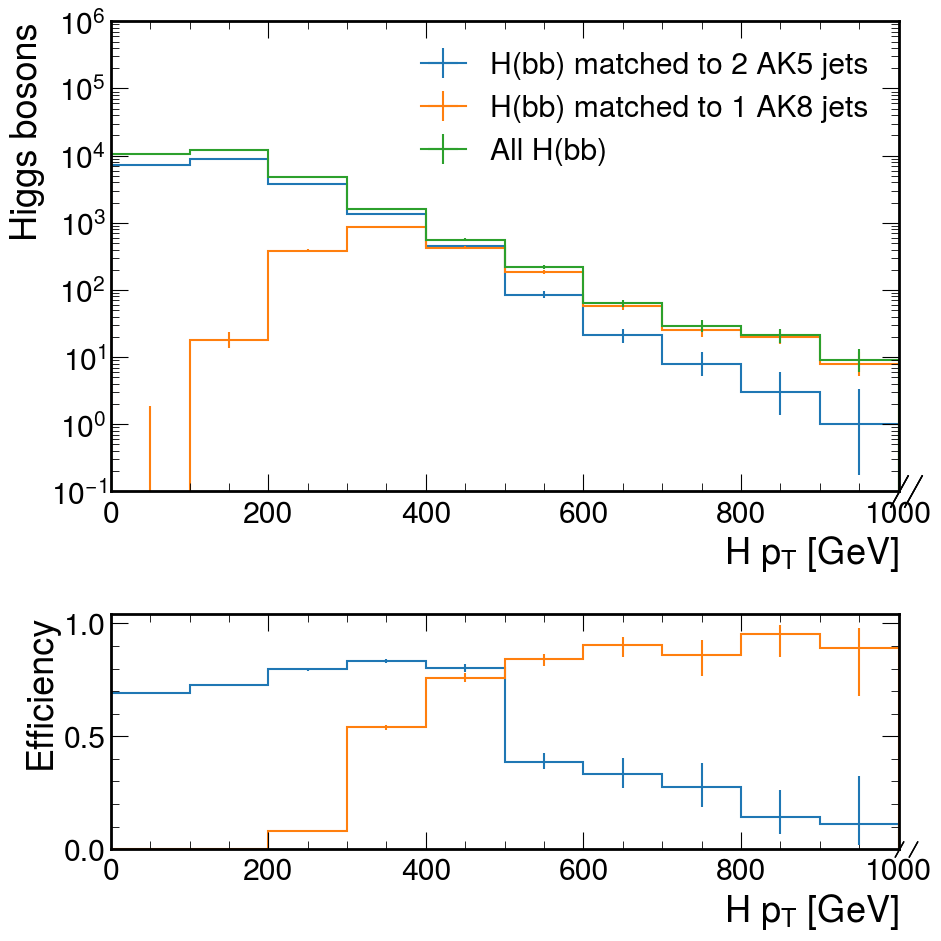

In [24]:
part_pid = arrays["Particle/Particle.PID"]  # PDG ID
part_m1 = arrays["Particle/Particle.M1"]
condition_hhh6b = np.logical_and(np.abs(part_pid) == 5, part_pid[part_m1] == 25)
# note: see some +/-15 PDG ID particles (taus) so h->tautau is turned on
# explicitly mask these out, just keeping hhh6b events
mask_hhh6b = ak.count(part_pid[condition_hhh6b], axis=-1) == 6

particles = ak.zip(
    {
        "pt": arrays["Particle/Particle.PT"],
        "eta": arrays["Particle/Particle.Eta"],
        "phi": arrays["Particle/Particle.Phi"],
        "mass": arrays["Particle/Particle.Mass"],
        "pid": part_pid,
        "m1": part_m1,
        "d1": arrays["Particle/Particle.D1"],
        "idx": ak.local_index(part_pid),
    },
    with_name="Momentum4D",
)[mask_hhh6b]

higgs_condition = np.logical_and(particles.pid == 25, np.abs(particles.pid[particles.d1]) == 5)
higgses = ak.to_regular(particles[higgs_condition], axis=1)
bquark_condition = np.logical_and(np.abs(particles.pid) == 5, particles.pid[particles.m1] == 25)
bquarks = ak.to_regular(particles[bquark_condition], axis=1)

jets = ak.zip(
    {
        "pt": arrays["Jet/Jet.PT"],
        "eta": arrays["Jet/Jet.Eta"],
        "phi": arrays["Jet/Jet.Phi"],
        "mass": arrays["Jet/Jet.Mass"],
        "idx": ak.local_index(arrays["Jet/Jet.PT"]),
        "flavor": arrays["Jet/Jet.Flavor"],
    },
    with_name="Momentum4D",
)[mask_hhh6b]

fjets = ak.zip(
    {
        "pt": arrays["FatJet/FatJet.PT"],
        "eta": arrays["FatJet/FatJet.Eta"],
        "phi": arrays["FatJet/FatJet.Phi"],
        "mass": arrays["FatJet/FatJet.Mass"],
        "idx": ak.local_index(arrays["FatJet/FatJet.PT"]),
    },
    with_name="Momentum4D",
)[mask_hhh6b]

fj_match = match_fjet_to_higgs(higgses, bquarks, fjets, ak.ArrayBuilder()).snapshot()
fj_higgses = higgses[fj_match > -1]

j_match = match_jets_to_higgs(higgses, bquarks, jets, ak.ArrayBuilder()).snapshot()
match = np.logical_and(j_match[:, :, 0] != j_match[:, :, 1], ak.all(j_match > -1, axis=-1))
j_higgses = higgses[match]

higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
higgs_pt.fill(ak.flatten(higgses.pt))

fj_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
fj_higgs_pt.fill(ak.flatten(fj_higgses.pt))

j_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
j_higgs_pt.fill(ak.flatten(j_higgses.pt))

j_ratio = j_higgs_pt / higgs_pt
j_ratio_uncert = np.abs(clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio)
fj_ratio = fj_higgs_pt / higgs_pt
fj_ratio_uncert = np.abs(clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio)

fig, axs = plt.subplots(2, 1, height_ratios=[2, 1])
hep.histplot(j_higgs_pt, label="H(bb) matched to 2 AK5 jets", ax=axs[0])
hep.histplot(fj_higgs_pt, label="H(bb) matched to 1 AK8 jets", ax=axs[0])
hep.histplot(higgs_pt, label="All H(bb)", ax=axs[0])
axs[0].set_ylabel("Higgs bosons")
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(1e-1, 1e6)
axs[0].semilogy()
axs[0].legend(loc="upper right")
hep.histplot(
    j_ratio,
    yerr=j_ratio_uncert,
    label="H(bb) matched to 2 AK5 jets",
    ax=axs[1],
)
hep.histplot(
    fj_ratio,
    yerr=fj_ratio_uncert,
    label="H(bb) matched to 1 AK8 jets",
    ax=axs[1],
)
axs[1].set_ylabel("Efficiency")
axs[1].set_xlim(0, 1000)
plt.tight_layout()
plt.show()

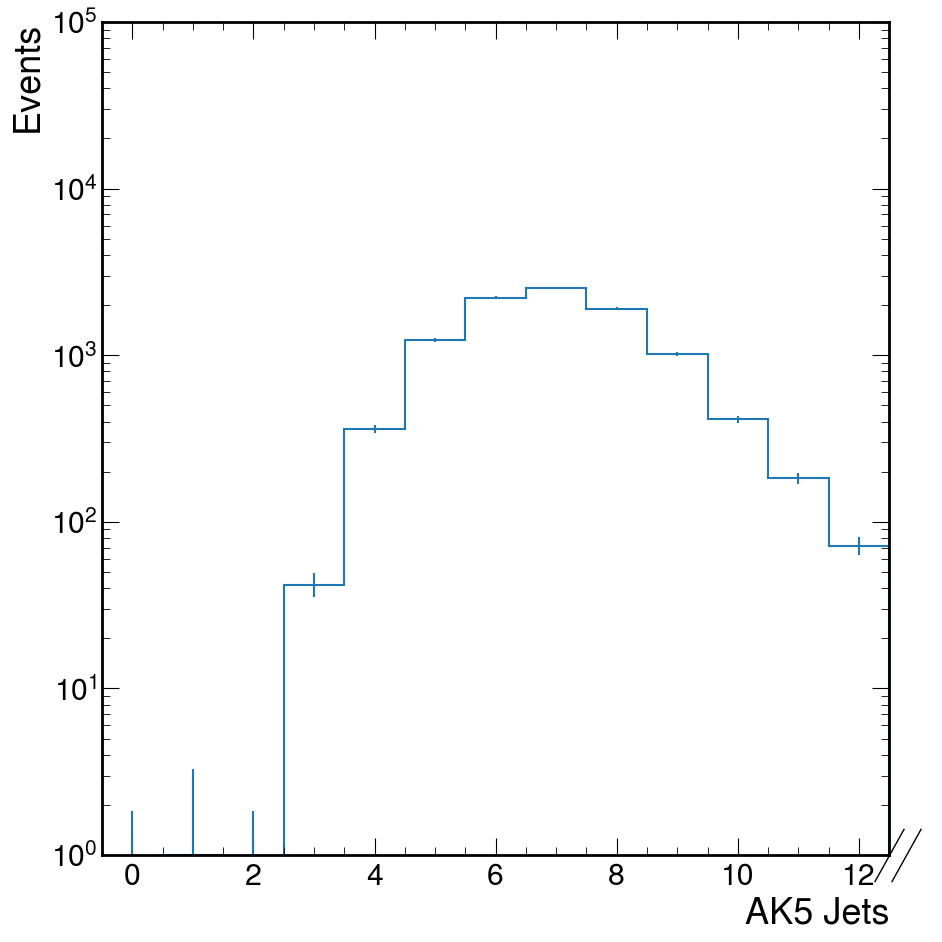

In [25]:
plt.figure()
n_jets = hist.Hist.new.Reg(13, -0.5, 12.5, name="AK5 Jets").Double()
n_jets.fill(ak.count(jets.pt, axis=-1))
hep.histplot(n_jets)
plt.ylabel("Events")
plt.xlabel("AK5 Jets")
plt.xlim(-0.5, 12.5)
plt.ylim(1, 1e5)
plt.semilogy()
plt.tight_layout()
plt.show()

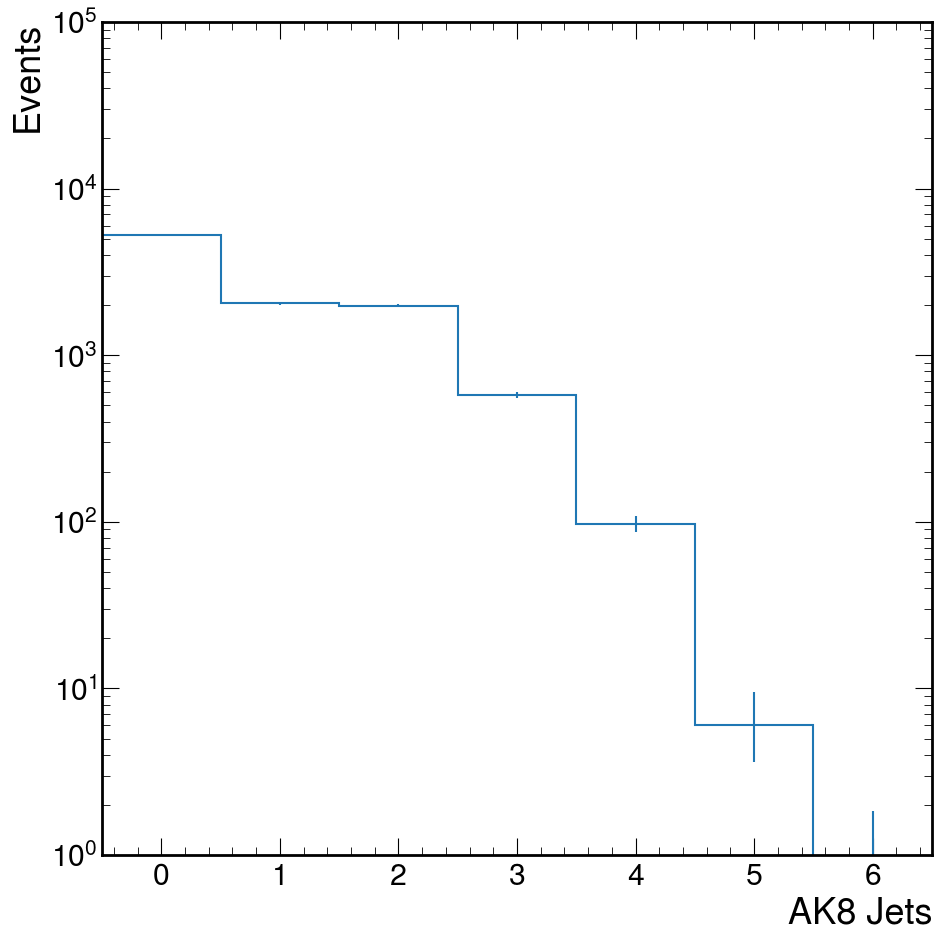

In [26]:
plt.figure()
n_fjets = hist.Hist.new.Reg(7, -0.5, 6.5, name="AK8 Jets").Double()
n_fjets.fill(ak.count(fjets.pt, axis=-1))
hep.histplot(n_fjets)
plt.ylabel("Events")
plt.xlabel("AK8 Jets")
plt.xlim(-0.5, 6.5)
plt.ylim(1, 1e5)
plt.semilogy()
plt.tight_layout()
plt.show()

### After minjet condition

In [27]:
# small-radius jet info
pt = arrays["Jet/Jet.PT"][mask_hhh6b]
eta = arrays["Jet/Jet.Eta"][mask_hhh6b]
phi = arrays["Jet/Jet.Phi"][mask_hhh6b]
mass = arrays["Jet/Jet.Mass"][mask_hhh6b]
btag = arrays["Jet/Jet.BTag"][mask_hhh6b]
flavor = arrays["Jet/Jet.Flavor"][mask_hhh6b]

# large-radius jet info
fj_pt = arrays["FatJet/FatJet.PT"][mask_hhh6b]
fj_eta = arrays["FatJet/FatJet.Eta"][mask_hhh6b]
fj_phi = arrays["FatJet/FatJet.Phi"][mask_hhh6b]
fj_mass = arrays["FatJet/FatJet.Mass"][mask_hhh6b]
fj_sdp4 = arrays["FatJet/FatJet.SoftDroppedP4[5]"][mask_hhh6b]
# first entry (i = 0) is the total SoftDropped Jet 4-momenta
# from i = 1 to 4 are the pruned subjets 4-momenta
fj_sdmass = np.sqrt(
    fj_sdp4.fE[..., 0] ** 2 - fj_sdp4.fP.fX[..., 0] ** 2 - fj_sdp4.fP.fY[..., 0] ** 2 - fj_sdp4.fP.fZ[..., 0] ** 2
)
fj_nsub = arrays["FatJet/FatJet.NSubJetsSoftDropped"][mask_hhh6b]
fj_taus = arrays["FatJet/FatJet.Tau[5]"][mask_hhh6b]
# just saving just tau21 and tau32, can save others if useful
fj_tau21 = fj_taus[..., 1] / fj_taus[..., 0]
fj_tau32 = fj_taus[..., 2] / fj_taus[..., 1]
fj_areap4 = arrays["FatJet/FatJet.Area"][mask_hhh6b]
fj_area = np.hypot(fj_areap4.fP.fX, fj_areap4.fP.fY)
fj_charge = arrays["FatJet/FatJet.Charge"][mask_hhh6b]
fj_ptd = arrays["FatJet/FatJet.PTD"][mask_hhh6b]
fj_ehadovereem = arrays["FatJet/FatJet.EhadOverEem"][mask_hhh6b]
fj_neutralenergyfrac = arrays["FatJet/FatJet.NeutralEnergyFraction"][mask_hhh6b]
fj_chargedenergyfrac = arrays["FatJet/FatJet.ChargedEnergyFraction"][mask_hhh6b]
fj_nneutral = arrays["FatJet/FatJet.NNeutrals"][mask_hhh6b]
fj_ncharged = arrays["FatJet/FatJet.NCharged"][mask_hhh6b]

/opt/conda/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [28]:
N_JETS = 10
N_FJETS = 3
MIN_JET_PT = 20
MIN_FJET_PT = 200
MIN_JETS = 6

mask_minjets = ak.num(pt[pt > MIN_JET_PT]) >= MIN_JETS

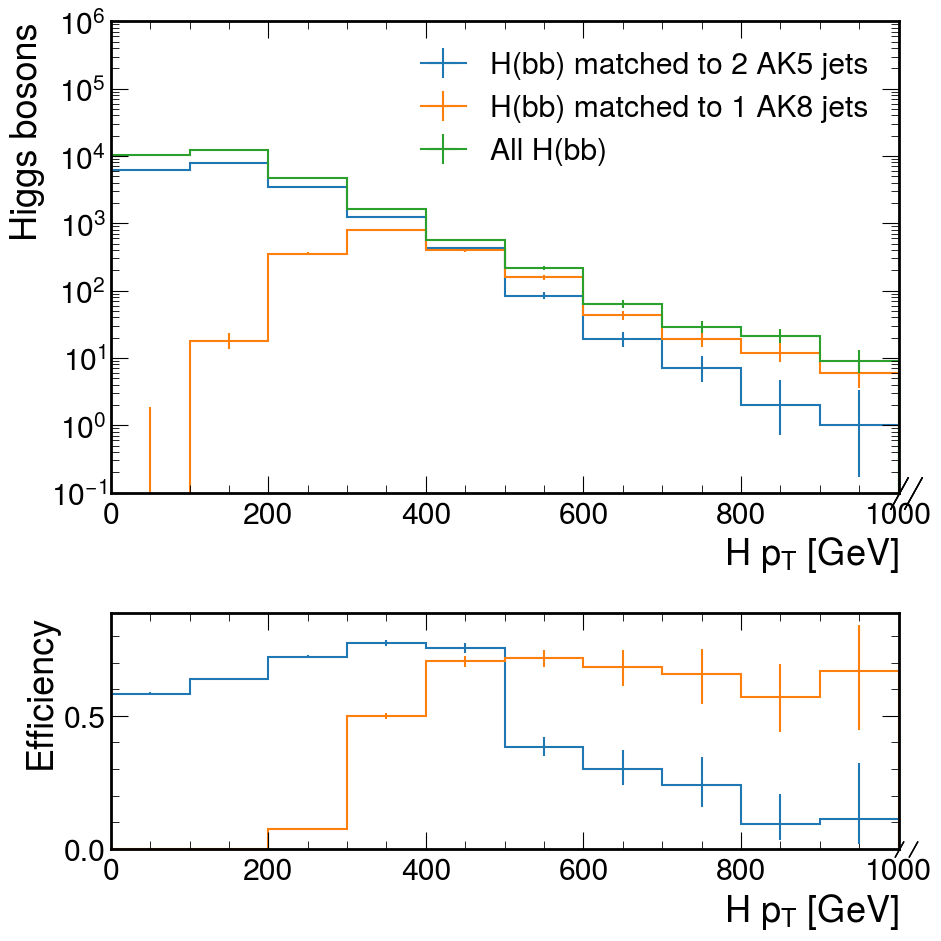

In [29]:
fj_match = fj_match[mask_minjets]
fj_higgses = higgses[mask_minjets][fj_match > -1]

j_match = j_match[mask_minjets]
match = np.logical_and(j_match[:, :, 0] != j_match[:, :, 1], ak.all(j_match > -1, axis=-1))
j_higgses = higgses[mask_minjets][match]

higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
higgs_pt.fill(ak.flatten(higgses.pt))

fj_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
fj_higgs_pt.fill(ak.flatten(fj_higgses.pt))

j_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
j_higgs_pt.fill(ak.flatten(j_higgses.pt))

j_ratio = j_higgs_pt / higgs_pt
j_ratio_uncert = np.abs(clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio)
fj_ratio = fj_higgs_pt / higgs_pt
fj_ratio_uncert = np.abs(clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio)

fig, axs = plt.subplots(2, 1, height_ratios=[2, 1])
hep.histplot(j_higgs_pt, label="H(bb) matched to 2 AK5 jets", ax=axs[0])
hep.histplot(fj_higgs_pt, label="H(bb) matched to 1 AK8 jets", ax=axs[0])
hep.histplot(higgs_pt, label="All H(bb)", ax=axs[0])
axs[0].set_ylabel("Higgs bosons")
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(1e-1, 1e6)
axs[0].semilogy()
axs[0].legend(loc="upper right")
hep.histplot(
    j_ratio,
    yerr=j_ratio_uncert,
    label="H(bb) matched to 2 AK5 jets",
    ax=axs[1],
)
hep.histplot(
    fj_ratio,
    yerr=fj_ratio_uncert,
    label="H(bb) matched to 1 AK8 jets",
    ax=axs[1],
)
axs[1].set_ylabel("Efficiency")
axs[1].set_xlim(0, 1000)
plt.tight_layout()
plt.show()

### Using match_higgs_to_fjet

In [30]:
higgs_idx = match_higgs_to_jet(higgses, bquarks, jets, ak.ArrayBuilder()).snapshot()
matched_fj_idx = match_fjet_to_jet(fjets, jets, ak.ArrayBuilder()).snapshot()
fj_higgs_idx = match_higgs_to_fjet(higgses, bquarks, fjets, ak.ArrayBuilder()).snapshot()

In [31]:
# when we sort by pT, are we sorting events or the particles within each events?
# pT shape: [event, var*jet]
# keep events with >= MIN_JETS small-radius jets
mask_minjets = ak.num(pt[pt > MIN_JET_PT]) >= MIN_JETS
# sort by btag first, then pt
# argsort return the indices in the descending order, 
# axis=-1 means sorting in the most nested structure
# so this sorted pTs in every event
sorted_by_pt = ak.argsort(pt, ascending=False, axis=-1)
sorted = ak.concatenate([sorted_by_pt[btag == 1], sorted_by_pt[btag == 0]], axis=-1)
btag = btag[sorted][mask_minjets]
pt = pt[sorted][mask_minjets]
eta = eta[sorted][mask_minjets]
phi = phi[sorted][mask_minjets]
mass = mass[sorted][mask_minjets]
flavor = flavor[sorted][mask_minjets]
higgs_idx = higgs_idx[sorted][mask_minjets]
matched_fj_idx = matched_fj_idx[sorted][mask_minjets]

# keep only top N_JETS
btag = btag[:, :N_JETS]
pt = pt[:, :N_JETS]
eta = eta[:, :N_JETS]
phi = phi[:, :N_JETS]
mass = mass[:, :N_JETS]
flavor = flavor[:, :N_JETS]
higgs_idx = higgs_idx[:, :N_JETS]
matched_fj_idx = matched_fj_idx[:, :N_JETS]

# sort by btag first, then pt
sorted_by_fj_pt = ak.argsort(fj_pt, ascending=False, axis=-1)
fj_higgs_idx = fj_higgs_idx[sorted_by_fj_pt][mask_minjets]

# mask to define zero-padded small-radius jets
mask = pt > MIN_JET_PT

# mask to define zero-padded large-radius jets
fj_mask = fj_pt > MIN_FJET_PT

# index of small-radius jet if Higgs is reconstructed
h1_bs = ak.local_index(higgs_idx)[higgs_idx == 1]
h2_bs = ak.local_index(higgs_idx)[higgs_idx == 2]
h3_bs = ak.local_index(higgs_idx)[higgs_idx == 3]

# index of large-radius jet if Higgs is reconstructed
h1_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 1]
h2_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 2]
h3_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 3]

# check/fix small-radius jet truth (ensure max 2 small-radius jets per higgs)
check = (
    np.unique(ak.count(h1_bs, axis=-1)).to_list()
    + np.unique(ak.count(h2_bs, axis=-1)).to_list()
    + np.unique(ak.count(h3_bs, axis=-1)).to_list()
)
if 3 in check:
    logging.warning("some Higgs bosons match to 3 small-radius jets! Check truth")

# check/fix large-radius jet truth (ensure max 1 large-radius jet per higgs)
fj_check = (
    np.unique(ak.count(h1_bb, axis=-1)).to_list()
    + np.unique(ak.count(h2_bb, axis=-1)).to_list()
    + np.unique(ak.count(h3_bb, axis=-1)).to_list()
)
if 2 in fj_check:
    logging.warning("some Higgs bosons match to 2 large-radius jets! Check truth")

h1_bs = ak.fill_none(ak.pad_none(h1_bs, 2, clip=True), -1)
h2_bs = ak.fill_none(ak.pad_none(h2_bs, 2, clip=True), -1)
h3_bs = ak.fill_none(ak.pad_none(h3_bs, 2, clip=True), -1)

h1_bb = ak.fill_none(ak.pad_none(h1_bb, 1, clip=True), -1)
h2_bb = ak.fill_none(ak.pad_none(h2_bb, 1, clip=True), -1)
h3_bb = ak.fill_none(ak.pad_none(h3_bb, 1, clip=True), -1)

h1_b1, h1_b2 = h1_bs[:, 0], h1_bs[:, 1]
h2_b1, h2_b2 = h2_bs[:, 0], h2_bs[:, 1]
h3_b1, h3_b2 = h3_bs[:, 0], h3_bs[:, 1]

# mask whether Higgs can be reconstructed as 2 small-radius jet
h1_mask = ak.all(h1_bs != -1, axis=-1)
h2_mask = ak.all(h2_bs != -1, axis=-1)
h3_mask = ak.all(h3_bs != -1, axis=-1)

# mask whether Higgs can be reconstructed as 1 large-radius jet
h1_fj_mask = ak.all(h1_bb != -1, axis=-1)
h2_fj_mask = ak.all(h2_bb != -1, axis=-1)
h3_fj_mask = ak.all(h3_bb != -1, axis=-1)

In [32]:
H_match_fj = fj_higgs_idx[fj_higgs_idx>-1]-1
fj_higgses_v2 = higgses[mask_minjets][H_match_fj]

H_match_j = higgs_idx[higgs_idx>-1]
H1_match_2j = ak.sum(H_match_j==1, axis=-1, keepdims=True)==2
H2_match_2j = ak.sum(H_match_j==2, axis=-1, keepdims=True)==2
H3_match_2j = ak.sum(H_match_j==3, axis=-1, keepdims=True)==2
H_match_j = ak.concatenate([H1_match_2j*1, H2_match_2j*2, H3_match_2j*3], axis=-1)
H_match_j = H_match_j[H_match_j>0]-1
j_higgses_v2 = higgses[mask_minjets][H_match_j]

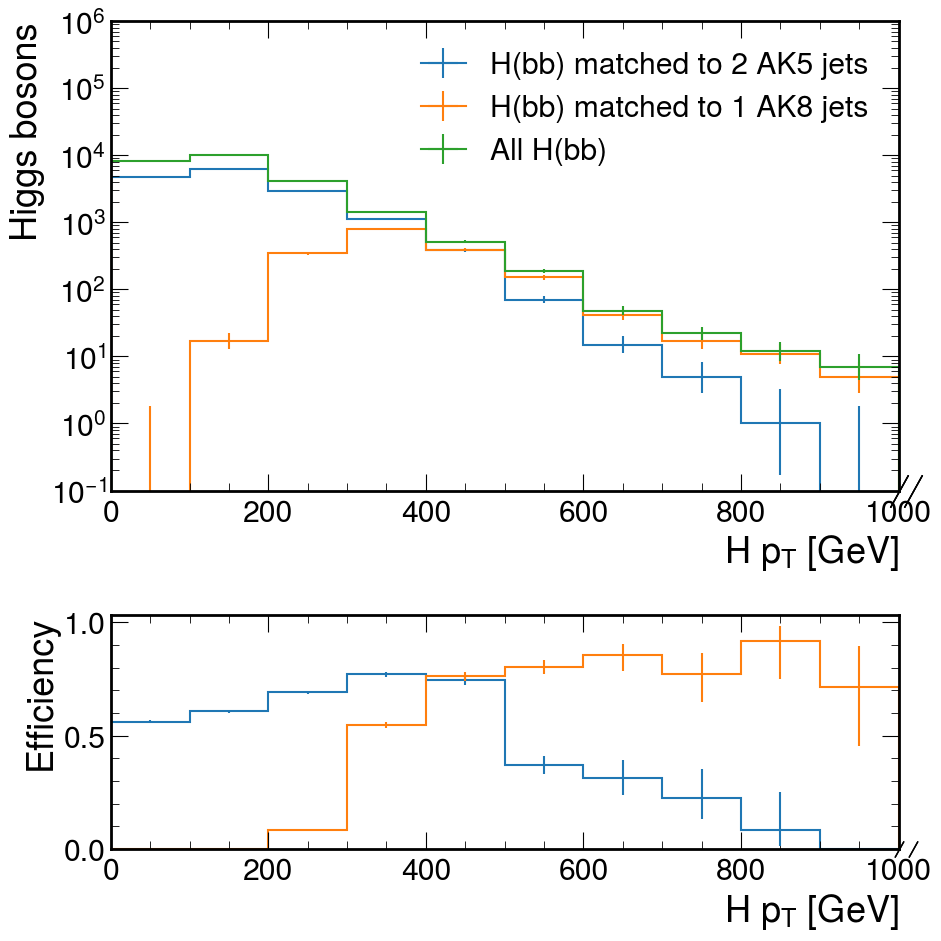

In [33]:
higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
higgs_pt.fill(ak.flatten(higgses[mask_minjets].pt))

fj_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
fj_higgs_pt.fill(ak.flatten(fj_higgses_v2.pt))

j_higgs_pt = hist.Hist.new.Reg(10, 0, 1000, name=r"H $p_T$ [GeV]").Double()
j_higgs_pt.fill(ak.flatten(j_higgses_v2.pt))


j_ratio = j_higgs_pt / higgs_pt
j_ratio_uncert = np.abs(clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio)
fj_ratio = fj_higgs_pt / higgs_pt
fj_ratio_uncert = np.abs(clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio)

fig, axs = plt.subplots(2, 1, height_ratios=[2, 1])
hep.histplot(j_higgs_pt, label="H(bb) matched to 2 AK5 jets", ax=axs[0])
hep.histplot(fj_higgs_pt, label="H(bb) matched to 1 AK8 jets", ax=axs[0])
hep.histplot(higgs_pt, label="All H(bb)", ax=axs[0])
axs[0].set_ylabel("Higgs bosons")
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(1e-1, 1e6)
axs[0].semilogy()
axs[0].legend(loc="upper right")
hep.histplot(
    j_ratio,
    yerr=j_ratio_uncert,
    label="H(bb) matched to 2 AK5 jets",
    ax=axs[1],
)
hep.histplot(
    fj_ratio,
    yerr=fj_ratio_uncert,
    label="H(bb) matched to 1 AK8 jets",
    ax=axs[1],
)
axs[1].set_ylabel("Efficiency")
axs[1].set_xlim(0, 1000)
plt.tight_layout()
plt.show()

In [70]:
ak.sum(ak.num(fj_higgses_v2, axis=1))

1787

In [76]:
def get_n_fj_higgs(in_file):
    # small-radius jet info
    part_pid = arrays["Particle/Particle.PID"]  # PDG ID
    part_m1 = arrays["Particle/Particle.M1"]
    condition_hhh6b = np.logical_and(np.abs(part_pid) == 5, part_pid[part_m1] == 25)
    # note: see some +/-15 PDG ID particles (taus) so h->tautau is turned on
    # explicitly mask these out, just keeping hhh6b events
    mask_hhh6b = ak.count(part_pid[condition_hhh6b], axis=-1) == 6

    particles = ak.zip(
        {
            "pt": arrays["Particle/Particle.PT"],
            "eta": arrays["Particle/Particle.Eta"],
            "phi": arrays["Particle/Particle.Phi"],
            "mass": arrays["Particle/Particle.Mass"],
            "pid": part_pid,
            "m1": part_m1,
            "d1": arrays["Particle/Particle.D1"],
            "idx": ak.local_index(part_pid),
        },
        with_name="Momentum4D",
    )[mask_hhh6b]

    higgs_condition = np.logical_and(particles.pid == 25, np.abs(particles.pid[particles.d1]) == 5)
    higgses = ak.to_regular(particles[higgs_condition], axis=1)
    bquark_condition = np.logical_and(np.abs(particles.pid) == 5, particles.pid[particles.m1] == 25)
    bquarks = ak.to_regular(particles[bquark_condition], axis=1)

    
    fjets = ak.zip(
    {
        "pt": arrays["FatJet/FatJet.PT"],
        "eta": arrays["FatJet/FatJet.Eta"],
        "phi": arrays["FatJet/FatJet.Phi"],
        "mass": arrays["FatJet/FatJet.Mass"],
        "idx": ak.local_index(arrays["FatJet/FatJet.PT"]),
    },
        with_name="Momentum4D",
    )[mask_hhh6b]
 
    N_JETS = 10
    N_FJETS = 3
    MIN_JET_PT = 20
    MIN_FJET_PT = 200
    MIN_JETS = 6
    
    fj_mask = fjets.pt > MIN_FJET_PT
    fjets = fjets[fj_mask]
    
    pt = arrays["Jet/Jet.PT"][mask_hhh6b]
    mask_minjets = ak.num(pt[pt > MIN_JET_PT]) >= MIN_JETS
    
    fj_higgs_idx = match_higgs_to_fjet(higgses, bquarks, fjets, ak.ArrayBuilder()).snapshot()
    sorted_by_fj_pt = ak.argsort(fjets.pt, ascending=False, axis=-1)
    fj_higgs_idx = fj_higgs_idx[sorted_by_fj_pt][mask_minjets]

    H_match_fj_idx = fj_higgs_idx[fj_higgs_idx>-1]
    
    n_fj_Higgs_bf = np.sum(fj_higgs_idx>0)
    n_higgs_evt_bf = np.sum(np.sum(H_match_fj_idx>0, axis=-1)>0)
    
    fj_higgs_idx = fj_higgs_idx[:, :N_FJETS]
    H_match_fj_idx = fj_higgs_idx[fj_higgs_idx>-1]
    n_fj_Higgs_aft = np.sum(fj_higgs_idx>0)
    n_higgs_evt_aft = np.sum(np.sum(H_match_fj_idx>0, axis=-1)>0)

    return [n_fj_Higgs_bf, n_higgs_evt_bf, n_fj_Higgs_aft, n_higgs_evt_aft] # number of events that has non-zero Higgs

In [78]:
in_filename = in_filenames[0]
N_fj_higgs = []
for i in range(5):
    prefix = i*10000
    with uproot.open(in_filename) as in_file:
        events = in_file["Delphes"]
        keys = (
            [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
            + [key for key in events.keys() if "Jet/Jet." in key]
            + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
        )
        arrays = events.arrays(keys, entry_start=prefix, entry_stop=prefix+10000)
    n_fj_higgs = get_n_fj_higgs(in_file)
    print(n_fj_higgs)
    N_fj_higgs.append(n_fj_higgs)

[1751, 1506, 1739, 1503]
[1787, 1526, 1773, 1524]
[1688, 1430, 1679, 1429]
[1618, 1390, 1608, 1389]
[1764, 1512, 1749, 1507]


In [71]:
in_filename = in_filenames[-1]
N_fj_higgs = []
for i in range(5):
    prefix = i*10000
    with uproot.open(in_filename) as in_file:
        events = in_file["Delphes"]
        keys = (
            [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
            + [key for key in events.keys() if "Jet/Jet." in key]
            + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
        )
        arrays = events.arrays(keys, entry_start=prefix, entry_stop=prefix+10000)
    n_fj_higgs = get_n_fj_higgs(in_file)
    print(n_fj_higgs)
    N_fj_higgs.append(n_fj_higgs)

[1708, 1442, 1695, 1439]
[1782, 1516, 1761, 1513]
[1710, 1447, 1695, 1446]
[1673, 1429, 1657, 1426]
[1726, 1483, 1710, 1480]


In [72]:
in_filename = in_filenames[10]
N_fj_higgs = []
for i in range(5):
    prefix = i*10000
    with uproot.open(in_filename) as in_file:
        events = in_file["Delphes"]
        keys = (
            [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
            + [key for key in events.keys() if "Jet/Jet." in key]
            + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
        )
        arrays = events.arrays(keys, entry_start=prefix, entry_stop=prefix+10000)
    n_fj_higgs = get_n_fj_higgs(in_file)
    print(n_fj_higgs)
    N_fj_higgs.append(n_fj_higgs)

[1708, 1473, 1701, 1468]
[1695, 1440, 1685, 1440]
[1650, 1412, 1636, 1407]
[1658, 1413, 1644, 1407]
[1773, 1515, 1756, 1514]


In [79]:
def get_n_j_higgs(in_file):
    # small-radius jet info
    part_pid = arrays["Particle/Particle.PID"]  # PDG ID
    part_m1 = arrays["Particle/Particle.M1"]
    condition_hhh6b = np.logical_and(np.abs(part_pid) == 5, part_pid[part_m1] == 25)
    # note: see some +/-15 PDG ID particles (taus) so h->tautau is turned on
    # explicitly mask these out, just keeping hhh6b events
    mask_hhh6b = ak.count(part_pid[condition_hhh6b], axis=-1) == 6

    particles = ak.zip(
        {
            "pt": arrays["Particle/Particle.PT"],
            "eta": arrays["Particle/Particle.Eta"],
            "phi": arrays["Particle/Particle.Phi"],
            "mass": arrays["Particle/Particle.Mass"],
            "pid": part_pid,
            "m1": part_m1,
            "d1": arrays["Particle/Particle.D1"],
            "idx": ak.local_index(part_pid),
        },
        with_name="Momentum4D",
    )[mask_hhh6b]

    higgs_condition = np.logical_and(particles.pid == 25, np.abs(particles.pid[particles.d1]) == 5)
    higgses = ak.to_regular(particles[higgs_condition], axis=1)
    bquark_condition = np.logical_and(np.abs(particles.pid) == 5, particles.pid[particles.m1] == 25)
    bquarks = ak.to_regular(particles[bquark_condition], axis=1)

    
    jets = ak.zip(
        {
            "pt": arrays["Jet/Jet.PT"],
            "eta": arrays["Jet/Jet.Eta"],
            "phi": arrays["Jet/Jet.Phi"],
            "mass": arrays["Jet/Jet.Mass"],
            "idx": ak.local_index(arrays["Jet/Jet.PT"]),
            "flavor": arrays["Jet/Jet.Flavor"],
        },
        with_name="Momentum4D",
    )[mask_hhh6b]
 
    N_JETS = 10
    N_FJETS = 3
    MIN_JET_PT = 20
    MIN_FJET_PT = 200
    MIN_JETS = 6
    
    pt = arrays["Jet/Jet.PT"][mask_hhh6b]
    btag = arrays["Jet/Jet.BTag"][mask_hhh6b]
    mask_minjets = ak.num(pt[pt > MIN_JET_PT]) >= MIN_JETS
    
    mask = pt > MIN_JET_PT
    jets = jets[mask]
    
    higgs_idx = match_higgs_to_jet(higgses, bquarks, jets, ak.ArrayBuilder()).snapshot()
    sorted_by_pt = ak.argsort(jets.pt, ascending=False, axis=-1)
    sorted = ak.concatenate([sorted_by_pt[btag == 1], sorted_by_pt[btag == 0]], axis=-1)
    higgs_idx = higgs_idx[sorted][mask_minjets]
    higgs_idx = higgs_idx[:, :N_JETS]
    
    H_match_j = higgs_idx[higgs_idx>-1]
    H1_match_2j = ak.sum(H_match_j==1, axis=-1, keepdims=True)==2
    H2_match_2j = ak.sum(H_match_j==2, axis=-1, keepdims=True)==2
    H3_match_2j = ak.sum(H_match_j==3, axis=-1, keepdims=True)==2
    H_match_j_idx = ak.concatenate([H1_match_2j*1, H2_match_2j*2, H3_match_2j*3], axis=-1)
    
    n_j_Higgs = np.sum(H_match_j_idx>0)
    n_higgs_evt = np.sum(np.sum(H_match_j_idx>0, axis=-1)>0)

    return [n_j_Higgs, n_higgs_evt] # number of events that has non-zero Higgs

In [80]:
in_filename = in_filenames[0]
N_fj_higgs = []
for i in range(5):
    prefix = i*10000
    with uproot.open(in_filename) as in_file:
        events = in_file["Delphes"]
        keys = (
            [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
            + [key for key in events.keys() if "Jet/Jet." in key]
            + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
        )
        arrays = events.arrays(keys, entry_start=prefix, entry_stop=prefix+10000)
    n_j_higgs = get_n_j_higgs(in_file)
    print(n_j_higgs)
    N_fj_higgs.append(n_j_higgs)

[15509, 7958]
[15434, 7973]
[15384, 7978]
[15174, 7873]
[15453, 7968]
